In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pathlib import Path 
import csv
from PIL import Image
import statistics
import math

In [3]:
path_notebook = os.path.abspath('')
path_lasot_data = os.path.join(path_notebook, "RepMet", "data", "LaSOT")
objects = ["book", "bottle", "coin", "cup", "robot", "rubicCube"]

In [4]:
split = "all"
videos_idxs = []
if split == "train":
    videos_idxs = range(15)
elif split == "val":
    videos_idxs = range(15, 18)
elif split == "test":
    videos_idxs = range(15, 20) # I know that each categorie in Lasot have 20 videos

else:
    videos_idxs = range(20)

In [21]:
# Code similar to LaSOT.py

rate_sample = 1
data = []
gt = []
ocl = []
out_view = []
shapes = [] # one shape per video


for idx, obj in enumerate(objects):
    for idx_video in range(20):
        video = os.path.join(path_lasot_data, obj, obj + "-" + str(idx_video+1))
        with open(os.path.join(video,'groundtruth.txt'), 'r') as f_gt:
            f_gt = f_gt.readlines()
            
        with open(os.path.join(video,'full_occlusion.txt'), 'r') as f_ocl:
            f_ocl = f_ocl.readlines() # all information is in one line
            rd_ocl = list(csv.reader(f_ocl))
            ocl.append(rd_ocl[0])
            
        with open(os.path.join(video,'out_of_view.txt'), 'r') as f_out_v:
            f_out_v = f_out_v.readlines()
            rd_out_v = list(csv.reader(f_out_v))
            out_view.append(rd_out_v[0])
        
        gt_dummy = []
        for idx, row in enumerate(f_gt):
            if (idx+1) % rate_sample == 0:
                #if not int(reader_occlusion[idx]) or not int(reader_out_of_view[idx]):
                #w, h = int(row[2]), int(row[3])
                #x, y = int(row[0]), int(row[1])
                # if the object is out of camera should be in the first five pixel in left and upper
                #if (w*4 < h or h*4 < w) or  (x < 5 or y < 5 or x > 15*w_img/16 or y > 15*h_img/16):
                #    bad_gt_idx.append(idx)
                #else:
                gt_dummy.append(row)
                
        gt.append(gt_dummy)
            
        data_dummy = []
        for idx, img in enumerate(sorted(glob.glob(os.path.join(video, "img", "*.jpg")), key=os.path.getmtime)):
            if (idx+1) % rate_sample == 0:
                #if not int(reader_occlusion[idx]) or not int(reader_out_of_view[idx]):
                #if idx not in bad_gt_idx:
                data_dummy.append(img)
                
        im = Image.open(img)
        shapes.append(im.size)
        data.append(data_dummy)
            
            
            
        

#### Información Esencial

LaSOT menciona en su pagina web que el dataset contiene: "70 categories with 1,400 videos, ~227G". Además existe una nueva actualización con nuevas categorias y esta contiene: "15 categories with 150 videos, ~59G".

fuente: http://vision.cs.stonybrook.edu/~lasot/download.html

#### Se realizan estadisticas solo con estas 6 categorias: [book, bottle, coin, cup, robot, rubicCube]

In [22]:
print(f"Total de imagenes: {sum([len(data_) for data_ in data])}")
print(f"Total de gt: {sum([len(gt_) for gt_ in gt])}")
print(f"Total de full_occlusion: {sum([len(ocl_) for ocl_ in ocl])}")
print(f"Total de out_of_view: {sum([len(out_view_) for out_view_ in out_view])}")

Total de imagenes: 289161
Total de gt: 289161
Total de full_occlusion: 289161
Total de out_of_view: 289161


In [23]:
print(f"Total de objetos ocluidos: {sum([ocl_.count('1') for ocl_ in ocl])}")
print(f"Total de objetos fuera de vista: {sum([out_v_.count('1') for out_v_ in out_view])}")

Total de objetos ocluidos: 1584
Total de objetos fuera de vista: 1412


##### Estadistica entre objetos

--------------------------------------------------book--------------------------------------------------

Total de imagenes: 41583


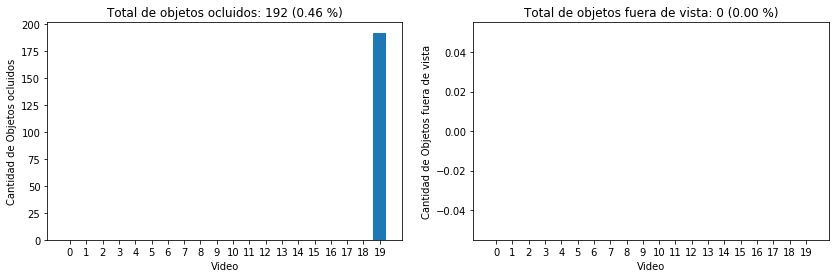

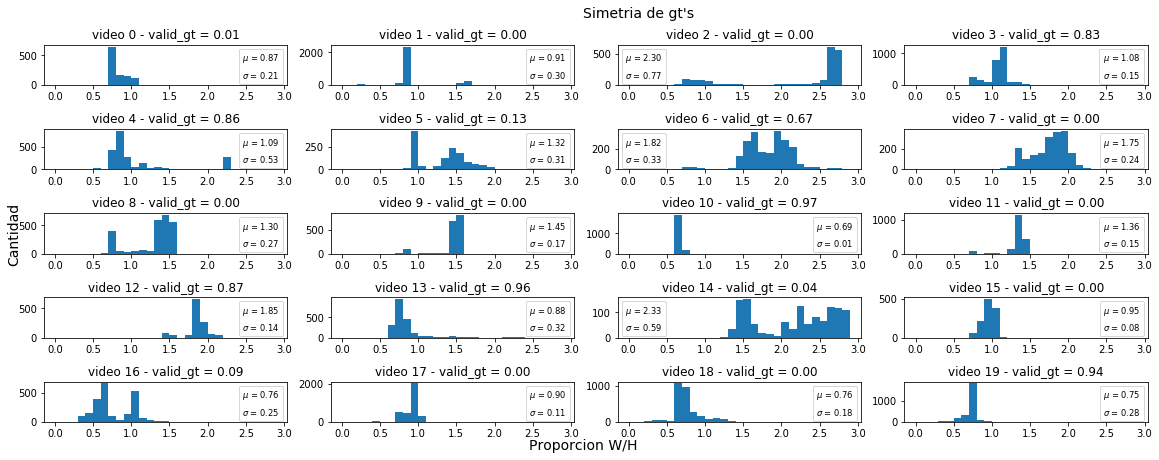

Cantidad de videos válidos para book: 10 / 20

--------------------------------------------------bottle--------------------------------------------------

Total de imagenes: 47026


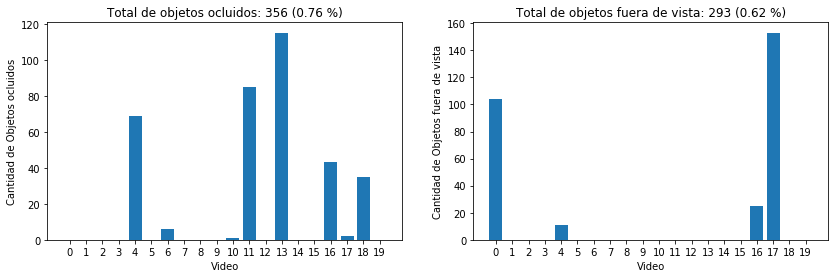

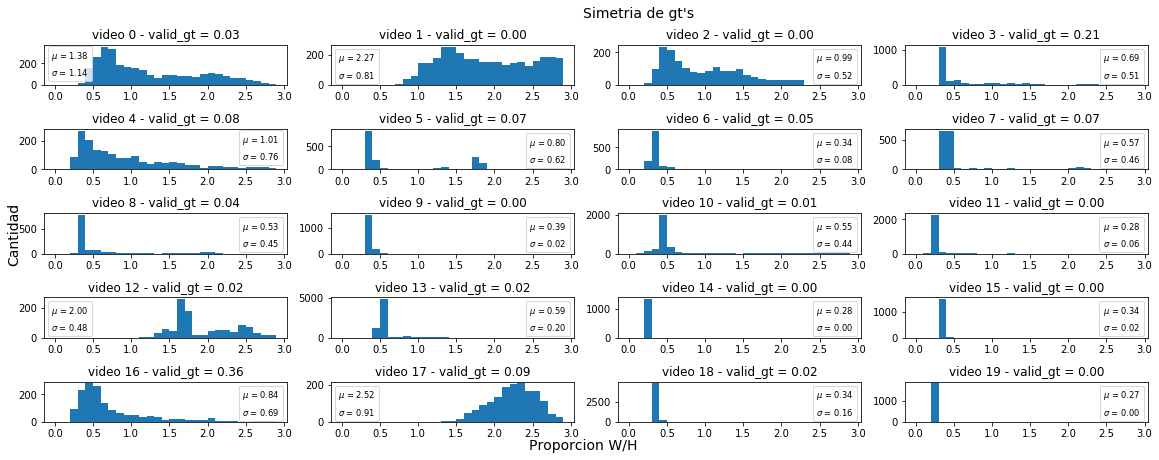

Cantidad de videos válidos para bottle: 13 / 20

--------------------------------------------------coin--------------------------------------------------

Total de imagenes: 37469


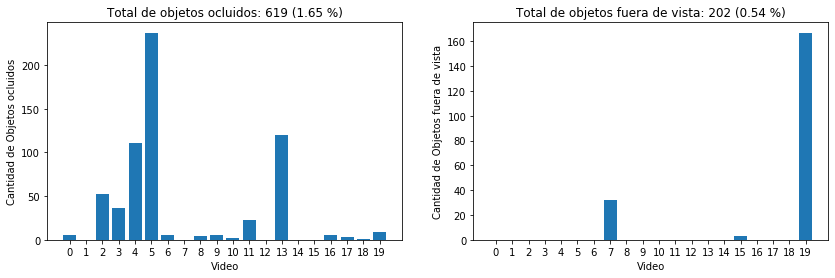

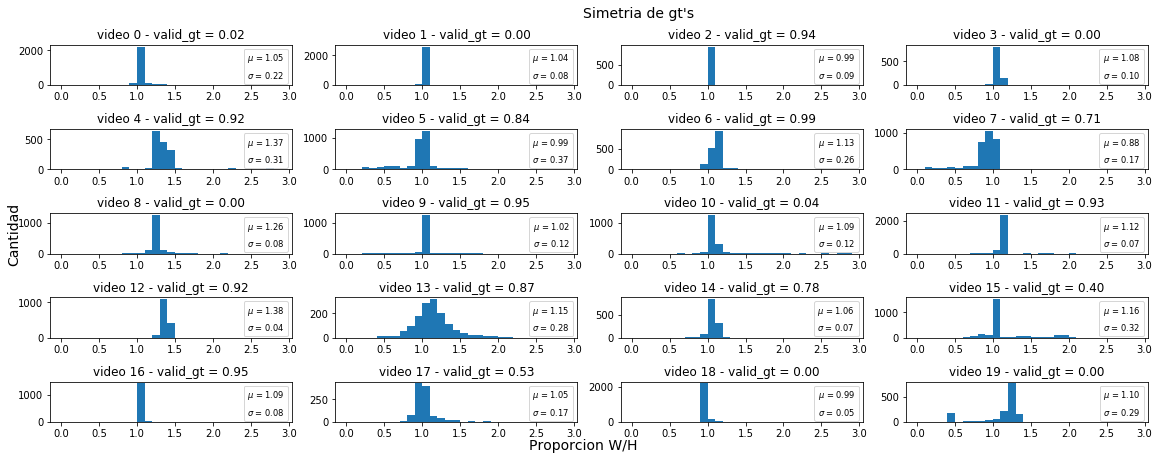

Cantidad de videos válidos para coin: 15 / 20

--------------------------------------------------cup--------------------------------------------------

Total de imagenes: 41095


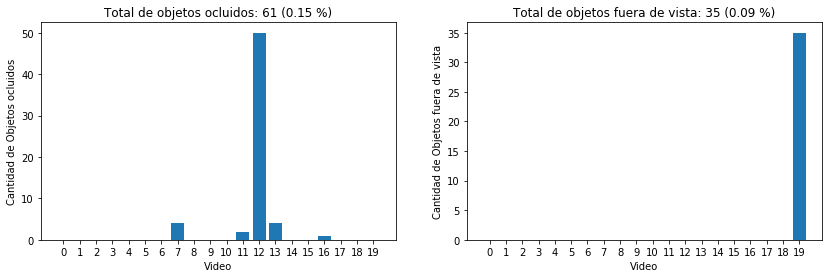

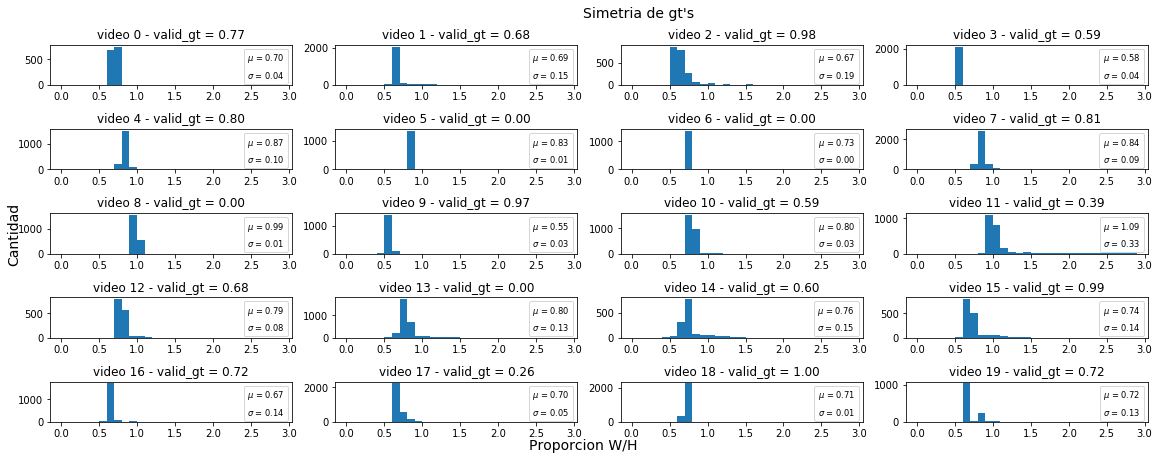

Cantidad de videos válidos para cup: 16 / 20

--------------------------------------------------robot--------------------------------------------------

Total de imagenes: 76164


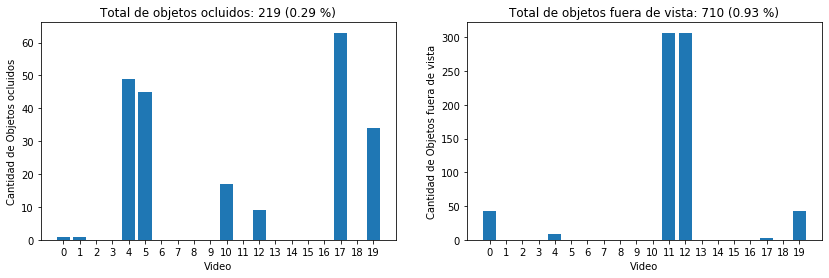

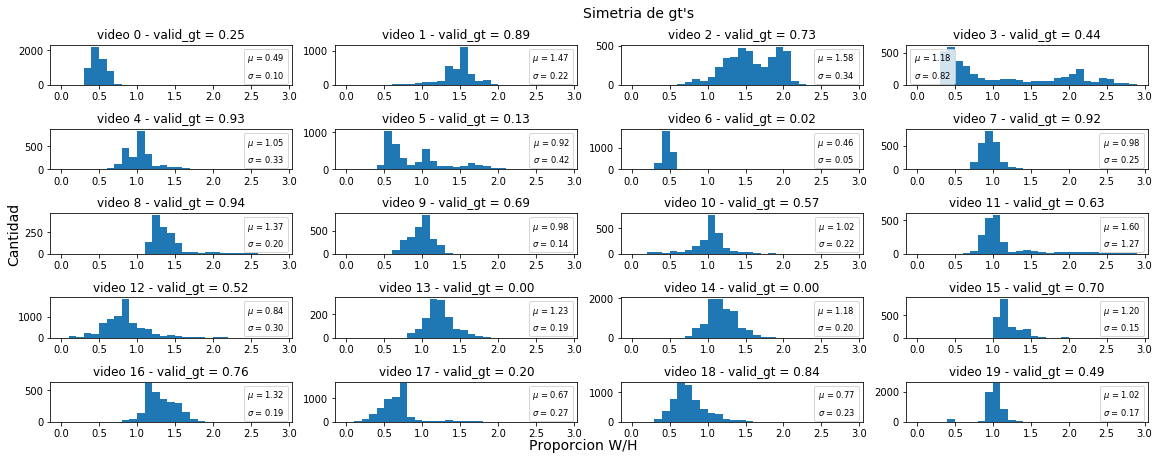

Cantidad de videos válidos para robot: 18 / 20

--------------------------------------------------rubicCube--------------------------------------------------

Total de imagenes: 45824


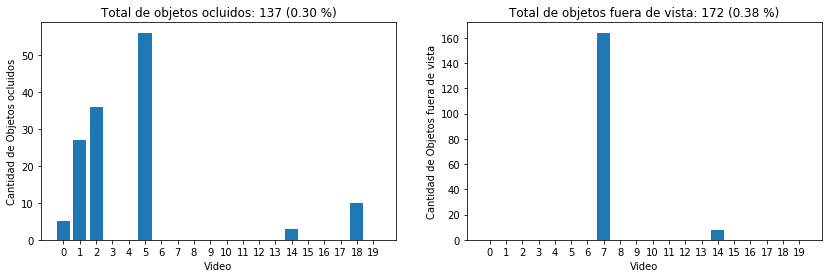

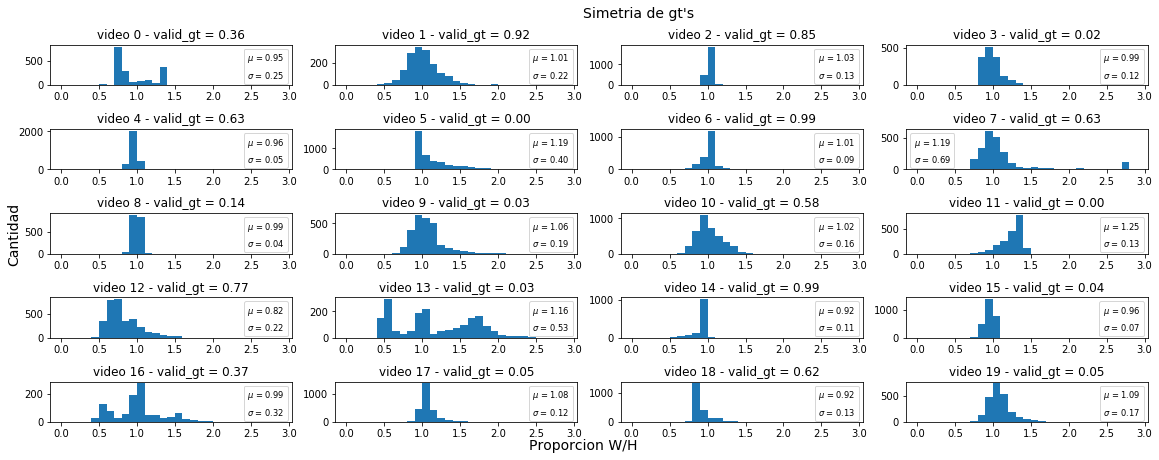

Cantidad de videos válidos para rubicCube: 18 / 20

---
Resumen:
Cantidad de videos válidos para book: 10 / 20
Cantidad de videos válidos para bottle: 13 / 20
Cantidad de videos válidos para coin: 15 / 20
Cantidad de videos válidos para cup: 16 / 20
Cantidad de videos válidos para robot: 18 / 20
Cantidad de videos válidos para rubicCube: 18 / 20

Cantidad de videos válidos para todos los objetos: 90 / 120 = 0.750000


In [27]:
prop_bbx = 1.5
valids_videos_all = []
for idx, obj in enumerate(objects):
    print('-'*50, end='')
    print(obj, end='')
    print('-'*50)
    print()
    total = sum([len(data_) for data_ in data[idx*20:(idx+1)*20]])
    ocl_idx = [ocl_.count('1') for ocl_ in ocl[idx*20:(idx+1)*20]]
    ocl_count = sum(ocl_idx)
    out_v_idx = [out_view_.count('1') for out_view_ in out_view[idx*20:(idx+1)*20]]
    out_v_count = sum(out_v_idx)
    gt_stat = [list(map(lambda x: float(x.split(',')[2])/float(x.split(',')[3]) , filter(lambda x: float(x.split(',')[3])>0, gt_)))
               for gt_ in gt[idx*20:(idx+1)*20]]
    
    print(f"Total de imagenes: {total}")
    
    plt.figure(figsize=(14,4))
    plt.subplot(1, 2, 1)
    plt.bar(range(20), ocl_idx)
    plt.xticks(range(20), [str(cnt) for cnt in range(20)])
    plt.xlabel("Video")
    plt.ylabel("Cantidad de Objetos ocluidos")
    plt.title(f"Total de objetos ocluidos: {ocl_count} ({float(100*ocl_count/total):.2f} %)")
    
    plt.subplot(1, 2, 2)
    plt.bar(range(20), out_v_idx)
    plt.xticks(range(20), [str(cnt) for cnt in range(20)])
    plt.xlabel("Video")
    plt.ylabel("Cantidad de Objetos fuera de vista")
    plt.title(f"Total de objetos fuera de vista: {out_v_count} ({float(100*out_v_count/total):.2f} %)")
    plt.show()
    
    fig, axs = plt.subplots(5, 4, figsize=(16, 6))
    axs = axs.flatten()
    fig.text(0.5, 0, 'Proporcion W/H', ha='center', fontsize=14)
    fig.text(0, 0.5, 'Cantidad', va='center', rotation='vertical', fontsize=14)
    bins = np.arange(0, 3, 0.1)
    
    valids_videos = 0
    
    for i in range(20):
        (w_im, h_im) = shapes[idx*20 + i]
        valids_gt = 0
        gt_ = gt[idx*20 + i]
        total_frames = len(gt_)
        for idx_video, frame_gt in enumerate(gt_):
            x_gt, y_gt = float(frame_gt.split(',')[0]), float(frame_gt.split(',')[1])
            w_gt, h_gt = float(frame_gt.split(',')[2]), float(frame_gt.split(',')[3])
            #r = math.sqrt((w_gt/2.0)**2 + (h_gt/2.0)**2)
            r = max(w_gt/2.0, h_gt/2.0)  # PL modificado a max( )
            x_gt_center, y_gt_center = x_gt + w_gt/2, y_gt + h_gt/2
            if x_gt_center - prop_bbx*r > 0 and \
               x_gt_center + prop_bbx*r < w_im and \
               y_gt_center - prop_bbx*r > 0 and \
               y_gt_center + prop_bbx*r < h_im and \
               w_gt >= 50 and \
               h_gt >= 50 and \
               w_gt / h_gt >= 0.5 and \
               h_gt / w_gt >= 0.5: 
            
                valids_gt += 1
                
        if (valids_gt > 0.8*20):
            valids_videos += 1
            
        mean = statistics.mean(gt_stat[i])
        std = statistics.stdev(gt_stat[i])
        axs[i].hist(gt_stat[i], bins=bins)
        
        extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
        labels = [r"$\mu$ = {:.2f}".format(mean), r"$\sigma$ = {:.2f}".format(std)]
        axs[i].legend(handles=[extra, extra], labels=labels, loc="best", fontsize='small', handlelength=0, handletextpad=0)
        axs[i].set_title(f"video {i} - valid_gt = {float(valids_gt)/total_frames:.2f}")
        
    plt.tight_layout()
    fig.text(0.5, 1, "Simetria de gt's", fontsize=14)
    plt.show()
    #print(f"Cantidad de gt's doblemente asimetrico: ")
    #print(f"Cantidad de gt's triplemente asimetrico: ")
    print("Cantidad de videos válidos para %s: %d / 20" % (obj, valids_videos))
    print()
    valids_videos_all.append(valids_videos)
    

print("---")

print("Resumen:")
for idx, obj in enumerate(objects):
  print("Cantidad de videos válidos para %s: %d / 20" % (obj, valids_videos_all[idx]))
print("")
sum_all = np.sum(valids_videos_all)
n_tot = len(objects)*20
print("Cantidad de videos válidos para todos los objetos: %d / %d = %f" % (sum_all, n_tot, sum_all/n_tot))

#### Aclaración: valid_gt es el radio de gt's del video correspondiente que cumple las siguientes condiciones:

$$ x_{gt-center} - 1.5r > 0 \quad \& \quad x_{gt-center} + 1.5r < w_{im}$$

$$ y_{gt-center} - 1.5r > 0 \quad \& \quad y_{gt-center} + 1.5r < h_{im}$$

book 13


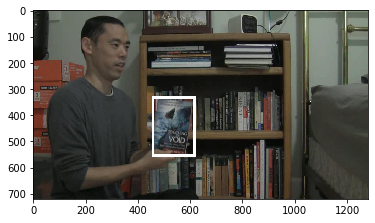

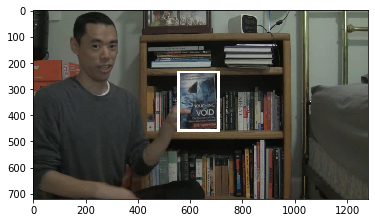

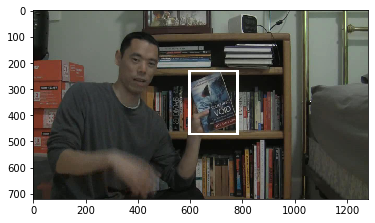

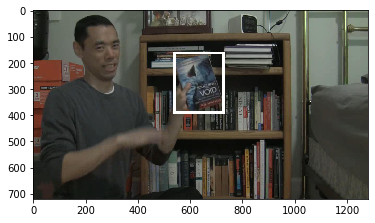

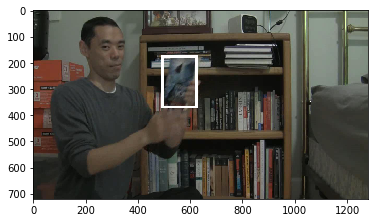

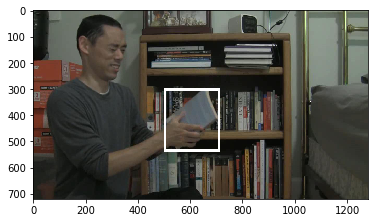

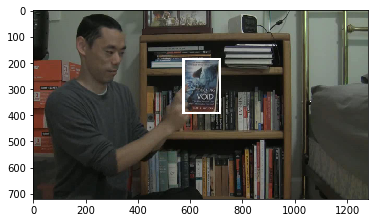

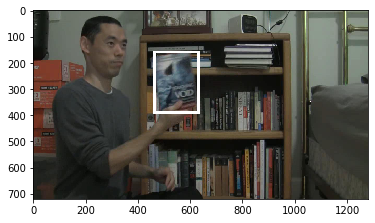

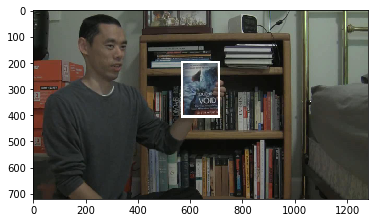

[565.0, 193.0, 715.0, 410.0]
(720, 1280, 3)


In [25]:
from PIL import ImageDraw

num_obj = 0
num_vid = 13

print(objects[num_obj] + " " + str(num_vid))

for idx in range(9):
    gt_ = gt[num_obj*20 + num_vid]
    num_frame = int( (idx) * len(gt_) / 8 )+1
    num_frame = min(num_frame, len(gt_)-1)
    
    frame_gt = gt_[num_frame]

    x_gt, y_gt = float(frame_gt.split(',')[0]), float(frame_gt.split(',')[1])
    w_gt, h_gt = float(frame_gt.split(',')[2]), float(frame_gt.split(',')[3])

    im = Image.open(os.path.join(path_lasot_data, objects[num_obj], objects[num_obj] + "-" + str(num_vid+1) +
                    "/img/" + "%08d" % (num_frame) + ".jpg"))

    draw = ImageDraw.Draw(im)

    draw.rectangle([x_gt, y_gt, x_gt+w_gt, y_gt+h_gt], width=10)

    plt.imshow(np.array(im))
    plt.show()

print([x_gt, y_gt, x_gt+w_gt, y_gt+h_gt])
print(np.array(im).shape)